# 1.04 - Modelling COB Peaks Timeseries
Using the peaks to assess the distribution of the data is a helpful approach to understand the distribution of meal intake over time. It has made it easier to assess the correctness of the data mapping to a daily pattern, especially given the issues with datetimes not aligning to the timezones that they are in. We'll now use the peaks to identify the COB values we are interested in modelling. The aim is to be able to assess what a standard day looks like and whether it is possible to identify where days are not standard, which may be due to errors in the data or due to the individual having a different pattern of meal intake. The peaks will be used to identify the COB values that are relevant for modelling, and then the timeseries will be used to assess the distribution and amplitude of those values over time. We will use the 15-minute resampled data here and focus on one of the candidates with the most defined distributions that shows a 3-meal intake clearly.

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonSBA, CrostonOptimized, TSB

from src.cob_analysis import Cob
from src.data_processing.read import read_profile_offsets_csv
from src.data_processing.read_preprocessed_df import ReadPreprocessedDataFrame
from src.configurations import Configuration, FifteenMinute
from src.config import INTERIM_DATA_DIR
from src.time_series_analysis import run_adf, p_q_result, ts_dist_plot, ts_plot, split_ts, ts_plot_cfs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
logger.remove()

candidates = [13029224, 21946407, 27700103, 32407882, 41131654, 42360672, 67208817, 74175219, 79526193, 86025410, 95851255, 96254963, 96805916, 97417885]
individual = 41131654
args = {'height': 15, 'distance': 5, 'suppress': False}
config = Configuration()

profile_offsets = read_profile_offsets_csv(config)

df = ReadPreprocessedDataFrame(FifteenMinute(), file_path=INTERIM_DATA_DIR / '15min_iob_cob_bg_insulin_need.csv').df
cob = Cob(df)
#cob.read_interim_data(file_name='15min_iob_cob_bg', sampling_rate=15)
df_all = cob.process_one_tz_individuals(profile_offsets, args)

Number of records: 599360
Number of people: 116
Systems used: 	['OpenAPS']
Categories (1, object): ['OpenAPS']
The following stats are based on parameters h=15 and d=5:
	Number of records: 2291636
	Number of days with peaks: 7626
	Number of peaks: 15951


The data has a 'cob max' column that we need to transform such that it only holds the values that are relevant for modelling. The peaks will be used to identify the COB values that are used for features. That removes any noise from other values. Note, the imputed values are not used and would be irrelevant anyway, given that we are focussing purely on the values that are peaks only. These would always be original values.

In [10]:
df_all.columns

Index(['cob max', 'day', 'time', 'cob interpolate', 'peak'], dtype='object')

In [7]:
df = df_all.loc[individual].copy()
df.index.freq = str(cob.sampling_rate) + 'min'  # Avoid FutureWarning

In [8]:
# Running a quick ADF test to check if the data is stationary
run_adf(df['cob max'])

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -26.97359102321359
P-Value: 0.0
Number of lags: 53
Number of observations: 36363
Critical Values: {'1%': np.float64(-3.9590189861090983), '5%': np.float64(-3.4106107449475744), '10%': np.float64(-3.1271211082131924)}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary.
A more negative test statistic indicates stronger evidence against the null hypothesis.


This shows that the data is showing stationarity, despite the fact that we can see the clustering of peaks on a over-imposed days. It is unsurprising considering:
a) the data is not consistently entered by the individual, and
b) we know the data is sparse, which combined will impact immediate lags. Therefore, we need to extend our approach to appreciate the seasonality, and are able to do so with  using the SARIMA model.

SARIMA is a seasonal extension of ARIMA, which is a popular time series forecasting method. It is particularly useful for data that exhibits seasonality, as it incorporates both non-seasonal and seasonal components. The SARIMA model can be expressed as:
$$
SARIMA(p, d, q)(P, D, Q)_s
$$
where:
- p: order of the non-seasonal autoregressive part
- d: degree of differencing for the non-seasonal part
-  q: order of the non-seasonal moving average part
- P: order of the seasonal autoregressive part
- D: degree of differencing for the seasonal part
- Q: order of the seasonal moving average part
- s: length of the seasonal cycle (e.g., 96 for 15-minute intervals over a day)
- The SARIMA model can be used to capture both the short-term and long-term patterns in the data, making it suitable for forecasting and understanding the underlying trends.

The model is defined by three main parameters: p, d, q (non-seasonal) and P, D, Q (seasonal), along with the seasonal period s. This seasonal period would be a day, considering we expect a person's eating pattern to be diurnal. The parameters would need to respond to the sampling rate. That used for example is 15 minutes, and the period would be 96 (24 hours * 60 minutes / 15 minutes).

However, with careful consideration, for this time series we don't witness a decay in the data points we are using as our random variable, therefore we should look to another method for this use. As a baseline, we'll look at Croston's Method (or SBA). `StatsForecast` offers a library of Croston-based (and similar) methods. The classic Croston's formulation is:
- $Y_t$ : Carbohydrate intake at time $t$.
- $Z_j$ : The $j^{th}$ non-zero carbohydrate intake value.
- $X_j$ : The $j^{th}$ inter-arrival time (number of periods between non-zero values).

Simple Exponential Smoothing (SES) for $Z_j$ and $X_j$:
$$s_j = \alpha \cdot Z_j + (1 - \alpha) \cdot s_{j-1}$$
where $\alpha$ is the smoothing parameter (0 < $\alpha$ < 1).
$$a_j = \beta \cdot X_j + (1 - \beta) \cdot a_{j-1}$$

The forecast for the next non-zero value is given by:
$$\hat{Y}_{t+h} = \frac{s_N}{a_N}$$
where $h$ is the forecast horizon and $N$ is the total number of non-zero intake events that have occurred in historical data up to the current time $t$. $s_N$ is the latest smoothed demand size, which is the exponentially smoothed average of all N non-zero demand values encountered in the historical data. $a_N$ is the latest smoothed interval, which is the exponentially smoothed average of all $N$ intervals between these non-zero demand occurrences.

Let's implement and see what the results look like. We will use the `StatsForecast` library to implement Croston's Method, and then plot the results to see how well it captures the peaks in the data.


In [11]:
# StatsForecast expects a specific DataFrame format or use the parameters. Here, we're aligned the column names to match the expected format: 'unique_id', 'ds' (datetime), 'y' (values)
df_croston = df.copy()
df_croston['y'] = np.where(df_croston['peak'] == 1, df_croston['cob max'], 0)
df_croston = (df_croston.
              reset_index().
              rename(columns={'datetime': 'ds'}).
              drop(columns=['cob max', 'day', 'time', 'cob interpolate', 'peak']))
df_croston['unique_id'] = '1'

def print_df_characteristics(df_croston):
    print("Sample Data Head (StatsForecast format):")
    print(df_croston.head(10))
    print("\nNumber of non-zero observations:", (df_croston['y'] > 0).sum())
    print("Total observations:", len(df_croston))
    print("Sparsity (proportion of zeros):", np.mean(df_croston['y'] == 0))

print_df_characteristics(df_croston)

Sample Data Head (StatsForecast format):
                         ds    y unique_id
0 2019-09-12 13:15:00+00:00  0.0         1
1 2019-09-12 13:30:00+00:00  0.0         1
2 2019-09-12 13:45:00+00:00  0.0         1
3 2019-09-12 14:00:00+00:00  0.0         1
4 2019-09-12 14:15:00+00:00  0.0         1
5 2019-09-12 14:30:00+00:00  0.0         1
6 2019-09-12 14:45:00+00:00  0.0         1
7 2019-09-12 15:00:00+00:00  0.0         1
8 2019-09-12 15:15:00+00:00  0.0         1
9 2019-09-12 15:30:00+00:00  0.0         1

Number of non-zero observations: 1269
Total observations: 36417
Sparsity (proportion of zeros): 0.9651536370376472


The result shows our data to be very sparse, as we would expect. Almost 97% zero-values. This can cause issues with the Croston's Method, especially if the smoothing parameters are not set correctly or if the data is too sparse, leading to forecasts that are too low or even zero due to numerical precision issues.

Some notes on the implementation using StatsForecast:
- For Croston's, you generally don't set alpha/beta directly in `CrostonClassic`/`SBA` as they use default values or optimized values. `CrostonOptimized` allows you to tune alpha and beta, or it can optimize them.
- The `TSB` model requires you to specify smoothing parameters (`alpha_d` for demand and `alpha_p` for period), which can be tuned based on your data characteristics.

In [12]:
def run_croston_models(df, sampling_rate=15):
    """
    Run Croston's models on the provided DataFrame.
    Returns a DataFrame with forecasts for each model.
    """
    intervals_per_day = 24 * 60 // sampling_rate

    models = [
        CrostonClassic(),  # Classic Croston's with default alpha=0.1 for both
        CrostonSBA(),      # Croston's with Syntetos-Boylan Approximation (bias-corrected)
        CrostonOptimized(),# Optimized Croston's (finds best alpha/beta within a range)
        TSB(alpha_d=0.2, alpha_p=0.2) # TSB model, requires smoothing parameters
    ]

    sf = StatsForecast(
        models=models,
        freq=str(sampling_rate)+'min',
        n_jobs=-1 # Use all available CPU cores for parallel processing
    )

    sf.fit(df=df)

    return sf.predict(h=intervals_per_day)  # Predict for the next 96 intervals (1 day), returns df

def print_croston_forecasts(df, sampling_rate=15):
    """
    Print the forecasts from Croston's models.
    """
    intervals_per_day = 24 * 60 // sampling_rate

    print(f"\nCrostonClassic Forecast (per 15-min interval): {df['CrostonClassic'].iloc[0]:.4f}")
    print(f"CrostonSBA Forecast (per 15-min interval): {df['CrostonSBA'].iloc[0]:.4f}")
    print(f"CrostonOptimized Forecast (per 15-min interval): {df['CrostonOptimized'].iloc[0]:.4f}")
    print(f"TSB Forecast (per 15-min interval): {df['TSB'].iloc[0]:.4f}")

    # Calculate average daily intake for each model
    for model_name in df.columns[2:]: # Skip 'unique_id' and 'ds'
        daily_avg = df[model_name].iloc[0] * intervals_per_day
        print(f"Average Daily Forecast ({model_name}): {daily_avg:.2f} units")

forecast_df1 = run_croston_models(df_croston)
print_croston_forecasts(forecast_df1)


CrostonClassic Forecast (per 15-min interval): 1.7803
CrostonSBA Forecast (per 15-min interval): 1.6912
CrostonOptimized Forecast (per 15-min interval): 1.7802
TSB Forecast (per 15-min interval): 0.6765
Average Daily Forecast (CrostonClassic): 170.90 units
Average Daily Forecast (CrostonSBA): 162.36 units
Average Daily Forecast (CrostonOptimized): 170.90 units
Average Daily Forecast (TSB): 64.95 units


The low forecasts may be for a number of reasons:
- The data is too sparse, leading to numerical precision issues.
- The smoothing parameters are not set correctly, leading to forecasts that are too low or even zero.
- The model is not able to capture the intermittent nature of the data, leading to forecasts that are not representative of the underlying demand.
- The model is not able to capture the seasonality of the data, leading to forecasts that are not representative of the underlying demand.
- Initialisation of $s_0$ and $a_0$ in Croston's Method can lead to zero forecasts if the initial values are not set correctly.

Following previous visual checks, we have noted with this individual that they have a period of days in which they have no peaks, and therefore no data to model. This is likely to be the cause of the low forecasts. We can check this by looking at the number of non-zero observations in the forecast data. We've created a function to remove days with zero intake from the data, so let's apply this and see if that changes the forecasts.

In [13]:
from src.time_series_analysis import remove_zero_or_null_days
print(f'Before removing zero intake days: {len(df.groupby("day").size())}')
df_croston = df_croston.set_index('ds')  # Ensure 'ds' is the index for time series operations
df_croston = remove_zero_or_null_days(df=df_croston, value_col='y')
print(f'After removing zero intake days: {len(df_croston.groupby(df_croston.index.date).size())}')
df_croston = df_croston.reset_index()  # Reset index to keep 'ds' as a column
print(df_croston.info())

Before removing zero intake days: 380
After removing zero intake days: 364
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34881 entries, 0 to 34880
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   ds         34881 non-null  datetime64[ns, UTC]
 1   y          34881 non-null  float64            
 2   unique_id  34881 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 817.7+ KB
None


In [14]:
forecast_df2 = run_croston_models(df_croston)
print_croston_forecasts(forecast_df2)


CrostonClassic Forecast (per 15-min interval): 1.7803
CrostonSBA Forecast (per 15-min interval): 1.6912
CrostonOptimized Forecast (per 15-min interval): 1.7802
TSB Forecast (per 15-min interval): 0.6765
Average Daily Forecast (CrostonClassic): 170.90 units
Average Daily Forecast (CrostonSBA): 162.36 units
Average Daily Forecast (CrostonOptimized): 170.90 units
Average Daily Forecast (TSB): 64.95 units


This has not produced the expected results but this can be explained by the fact that - even though the gaps have been effectively removed - Croston's method will still count the gap in its inter-arrival time, drastically inflating the $a_N$ and pushing the prediction down, given it is the denominator (and especially where $\alpha$ and $\beta$ are small). A function has been created that splits the dataframe into a list of separate ones based on a threshold of day gaps, set here to 3.

In [15]:
from src.time_series_analysis import split_on_time_gaps

split_dfs = split_on_time_gaps(df=df_croston.set_index('ds'), value_col='y', days_threshold=3)

print(f'Number of split dfs: {len(split_dfs)}')
for i, df in enumerate(split_dfs):
    print(f'Split DataFrame {i+1} - Number of days: {len(df.groupby(df.index.date).size())}, Start: {df.index.min()}, End: {df.index.max()}')

Number of split dfs: 2
Split DataFrame 1 - Number of days: 3, Start: 2019-09-12 13:15:00+00:00, End: 2019-09-14 23:45:00+00:00
Split DataFrame 2 - Number of days: 361, Start: 2019-09-28 00:00:00+00:00, End: 2020-09-25 21:15:00+00:00


In [16]:
forecast_df3 = run_croston_models(split_dfs[1].reset_index('ds'))
print_croston_forecasts(forecast_df3)


CrostonClassic Forecast (per 15-min interval): 1.7803
CrostonSBA Forecast (per 15-min interval): 1.6912
CrostonOptimized Forecast (per 15-min interval): 1.7802
TSB Forecast (per 15-min interval): 0.6765
Average Daily Forecast (CrostonClassic): 170.90 units
Average Daily Forecast (CrostonSBA): 162.36 units
Average Daily Forecast (CrostonOptimized): 170.90 units
Average Daily Forecast (TSB): 64.95 units


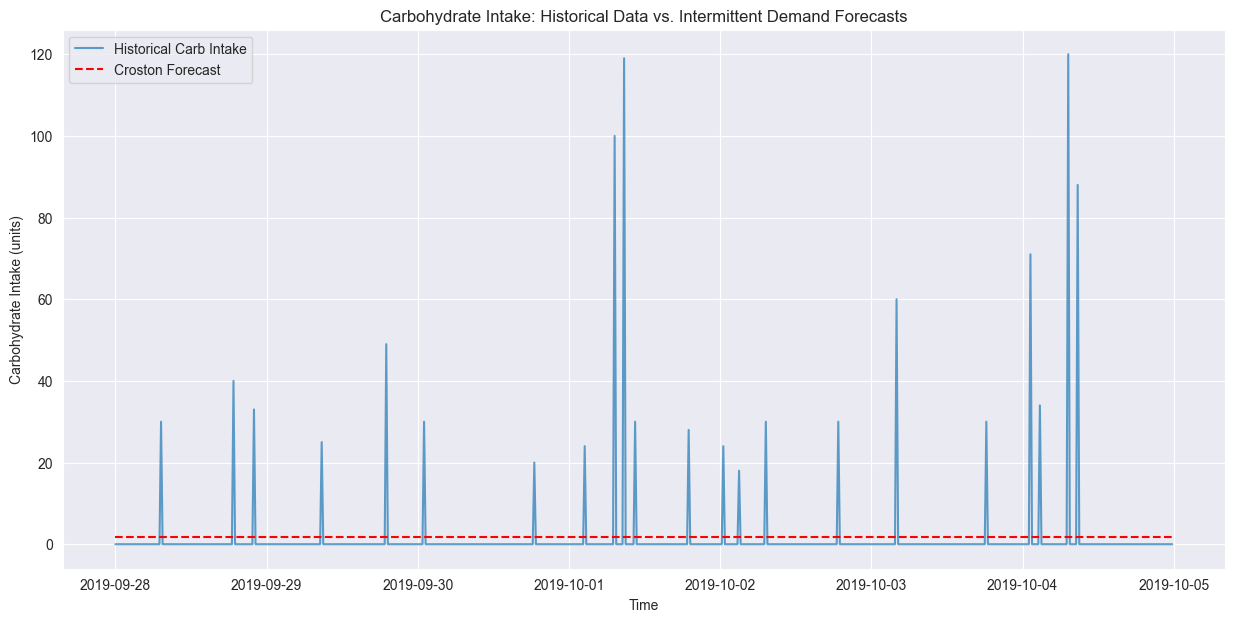

In [17]:
# Merge historical data with forecasts for plotting
intervals_per_day = 24 * 60 // 15
week = 7 * intervals_per_day
pred_df = split_dfs[1]
pred_df['CrostonPred'] = forecast_df3['CrostonOptimized'].iloc[0]
plot_df = pred_df.iloc[:week]
plt.figure(figsize=(15, 7))
plt.plot(plot_df.index, plot_df['y'], label='Historical Carb Intake', alpha=0.7)
plt.plot(plot_df.index, plot_df['CrostonPred'], label='Croston Forecast', color='red', linestyle='--')
plt.title('Carbohydrate Intake: Historical Data vs. Intermittent Demand Forecasts')
plt.xlabel('Time')
plt.ylabel('Carbohydrate Intake (units)')
plt.legend()
plt.grid(True)
plt.show()


We can see the Croston forecast is a very crude method and could only be considered as a baseline. We'll use a general metric to put a metric to the accuracy, Mean Absolute Scaled Error:

_Mean Absolute Scaled Error (MASE)_
_An error measure that is used for model accuracy. It is the MAE divided by the MAE of the naive model. The naive model is one that predicts the value at time point t as the previous historical value. Scaling by this error means that you can evaluate how good the model is compared to the naive model. If the MASE is greater than 1, then the model is worse than the naive model. The lower the MASE, the better the model is compared to the naive model._ https://www.ibm.com/docs/en/cognos-analytics/11.1.x?topic=forecasting-statistical-details



In [18]:
import pandas as pd
import numpy as np
from utilsforecast.losses import mase
from utilsforecast.evaluation import evaluate
from functools import partial
from src.time_series_analysis import split_ts

# --- 1. Prepare your data ---
# Assume 'df' is your original DataFrame with 'unique_id', 'ds', 'y'
# For intermittent data, it's crucial to have a 'unique_id' even if it's just one series.
# This structure is expected by utilsforecast.
# For MASE, the train set is used to calculate the scaling factor (naive MAE)
train_df, test_df = split_ts(pred_df, 0.8)
train_df.drop(columns=['CrostonPred'], inplace=True)

Min date: 2019-09-28 00:00:00+00:00
Max date: 2020-09-25 21:15:00+00:00
Number of values: 34646
Train set size: 27717
Test set size: 6929


The following implementation uses the evaluate function which is recommended for structured data, especially useful if you have multiple time series (multiple unique_id's) or if you want to calculate multiple metrics at once, which we may in the future. The `evaluate` function expects a DataFrame with 'unique_id', 'ds', 'y', and columns for your model's predictions. Add the 'y' from the test set back to the test_df for evaluation.

In [19]:
train_df.head()

,y,unique_id
ds,,
2019-09-28 00:00:00+00:00,0.0,1
2019-09-28 00:15:00+00:00,0.0,1
2019-09-28 00:30:00+00:00,0.0,1
2019-09-28 00:45:00+00:00,0.0,1
2019-09-28 01:00:00+00:00,0.0,1


In [20]:
# Define the MASE metric with optional seasonality
# Use functools.partial to pre-set the seasonality argument if needed
mase_metric = partial(mase, seasonality=intervals_per_day)

# Evaluate the model
evaluation_results = evaluate(
    df=test_df,
    metrics=[mase_metric], # Pass the mase function (or partial)
    models=['CrostonPred'], # The column name of your predictions
    train_df=train_df, # Crucial for MASE to calculate the scaling factor
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

print("\nMASE using utilsforecast.evaluation.evaluate:")
print(evaluation_results)

overall_mase = evaluation_results['CrostonPred'].mean()
print(f"\nOverall MASE: {overall_mase:.4f}")



MASE using utilsforecast.evaluation.evaluate:
  unique_id metric  CrostonPred
0         1   mase     1.164728

Overall MASE: 1.1647
